# Run with a spinup and GCM data

The initial state of glaciers play a large role for the model output. In this example we illustrate how to “spinup” a glacier (e.g.: make them grow) before running over the period of intrest. For this example we use climate data from the CESM Last Millennium Ensemble.

In [1]:
# Libs
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import tasks, utils, workflow
from oggm.workflow import execute_entity_task
from oggm.utils import get_demo_file

In [2]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_spinup_run')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# Use multiprocessing?
cfg.PARAMS['use_multiprocessing'] = False

2021-02-10 22:46:43: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-10 22:46:43: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-02-10 22:46:43: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-10 22:46:43: oggm.utils: Checking the download verification file checksum...


Pre-processed directories are being used here.

In [3]:
# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large
cfg.PARAMS['border'] = 80

# Go - initialize glacier directories
gdirs = workflow.init_glacier_regions(['RGI60-11.00897'], from_prepro_level=4)

2021-02-10 22:46:45: oggm.cfg: PARAMS['border'] changed from `40` to `80`.
2021-02-10 22:46:45: oggm.workflow: init_glacier_regions from prepro level 4 on 1 glaciers.
2021-02-10 22:46:45: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-10 22:46:45: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L3-L5_files/CRU/centerlines/qc3/pcp2.5/no_match/RGI62/b_080/L4/RGI60-11/RGI60-11.00.tar


Here the paths to the CESM-LME files are set. (The demo files that are being used in this example don't contain the whole last millennium, neither do they have the global coverage that they original files have. These demo files have been made for test purposes and to reduces the time it takes to run the example. If you use the demo files for a glacier outside the domain, you won't get an error. Instead the climate of the nearest point to the glacier that is available in the demo files will be used, which could be thousends of kilometers away.)

In [4]:
# Additional climate file (CESM)
cfg.PATHS['cesm_temp_file'] = get_demo_file('cesm.TREFHT.160001-200512'
                                            '.selection.nc')
cfg.PATHS['cesm_precc_file'] = get_demo_file('cesm.PRECC.160001-200512'
                                             '.selection.nc')
cfg.PATHS['cesm_precl_file'] = get_demo_file('cesm.PRECL.160001-200512'
                                             '.selection.nc')
execute_entity_task(tasks.process_cesm_data, gdirs);

2021-02-10 22:46:49: oggm.workflow: Execute entity task process_cesm_data on 1 glaciers
2021-02-10 22:46:49: oggm.shop.gcm_climate: (RGI60-11.00897) process_cesm_data
2021-02-10 22:46:49: oggm.shop.gcm_climate: (RGI60-11.00897) process_gcm_data


[None]

Here the CESM-LME data is being pre-processed. This process makes use of the delta method and uses scaled temperature anomalies by default (it is strongly recommended to use this default setting of scaling the temperature anaomalies, unless you have very good reasons not to do so).

In [5]:
execute_entity_task(tasks.process_cesm_data, gdirs)

2021-02-10 22:46:50: oggm.workflow: Execute entity task process_cesm_data on 1 glaciers
2021-02-10 22:46:50: oggm.shop.gcm_climate: (RGI60-11.00897) process_cesm_data
2021-02-10 22:46:50: oggm.shop.gcm_climate: (RGI60-11.00897) process_gcm_data


[None]

In [6]:
# Run the last 200 years with the default starting point (current glacier)
# and CESM data as input
execute_entity_task(tasks.run_from_climate_data, gdirs,
                    climate_filename='gcm_data',
                    ys=1801, ye=2000,
                    output_filesuffix='_no_spinup')

2021-02-10 22:46:55: oggm.workflow: Execute entity task run_from_climate_data on 1 glaciers
2021-02-10 22:46:55: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_no_spinup
2021-02-10 22:46:56: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_no_spinup


In [7]:
# Run the spinup simulation - t* climate with a cold temperature bias
execute_entity_task(tasks.run_constant_climate, gdirs,
                    nyears=100, bias=0, temperature_bias=-0.5,
                    output_filesuffix='_spinup')
# Run a past climate run based on this spinup
execute_entity_task(tasks.run_from_climate_data, gdirs,
                    climate_filename='gcm_data',
                    ys=1801, ye=2000,
                    init_model_filesuffix='_spinup',
                    output_filesuffix='_with_spinup')

2021-02-10 22:47:01: oggm.workflow: Execute entity task run_constant_climate on 1 glaciers
2021-02-10 22:47:01: oggm.core.flowline: (RGI60-11.00897) run_constant_climate_spinup
2021-02-10 22:47:01: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_spinup
2021-02-10 22:47:06: oggm.workflow: Execute entity task run_from_climate_data on 1 glaciers
2021-02-10 22:47:06: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_with_spinup
2021-02-10 22:47:06: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_with_spinup


When starting from a spin-up, by default the last year of the spin-up is being used to initialize a glacier. With init_model_yr, you can select any other year from the spin-up as initial year.

In [8]:
# Run a past climate run based on this spinup
execute_entity_task(tasks.run_from_climate_data, gdirs,
                    climate_filename='gcm_data',
                    ys=1801, ye=2000, init_model_yr=50,
                    init_model_filesuffix='_spinup',
                    output_filesuffix='_with_spinup_50yr')

2021-02-10 22:47:12: oggm.workflow: Execute entity task run_from_climate_data on 1 glaciers
2021-02-10 22:47:12: oggm.core.flowline: (RGI60-11.00897) run_from_climate_data_with_spinup_50yr
2021-02-10 22:47:13: oggm.core.flowline: (RGI60-11.00897) flowline_model_run_with_spinup_50yr


In [9]:
# Compile output
utils.compile_glacier_statistics(gdirs)
ds1 = utils.compile_run_output(gdirs, input_filesuffix='_no_spinup')
ds2 = utils.compile_run_output(gdirs, input_filesuffix='_with_spinup')
ds3 = utils.compile_run_output(gdirs, input_filesuffix='_with_spinup_50yr')

2021-02-10 22:47:18: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers
2021-02-10 22:47:18: oggm.utils: (RGI60-11.00897) glacier_statistics
2021-02-10 22:47:18: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-02-10 22:47:18: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-02-10 22:47:18: oggm.utils: Applying compile_run_output on 1 gdirs.


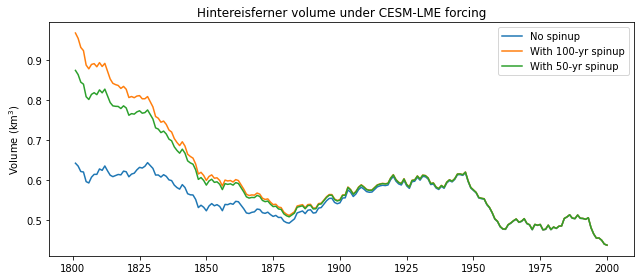

In [10]:
# Plot
f, ax = plt.subplots(figsize=(9, 4))
(ds1.volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='No spinup')
(ds2.volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='With 100-yr spinup')
(ds3.volume.sum(dim='rgi_id') * 1e-9).plot(ax=ax, label='With 50-yr spinup')
ax.set_ylabel('Volume (km$^3$)')
ax.set_xlabel('')
ax.set_title('Hintereisferner volume under CESM-LME forcing')
plt.legend()
plt.tight_layout()

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)